In [2]:
import sys, os

import numpy as np

from scipy import optimize


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
current_palette = sns.color_palette()

Here, I model the fund as a learning agent, which is able to adjust its demand function over time

In [3]:
from thurner_model import NoiseTrader
import plotting

In [4]:
V = 1
N = 1000

In [5]:
class Fund:
    """
    The funds in our model are value investors who base 
    their demand D_h_t on a mispricing signal m_t = V - p_t.
    The perceived fundamental value V is held constant and 
    is the same for the noise traders and for all funds
    
    Funds differ only according to an aggression parameter 
    beta_h that represents how sensitive their response is 
    to the signal m.
    """
    
    initial_wealth = 2
    lambda_max = 20
    
    def __init__(self, beta):
        self.beta = beta
        self.cash = self.initial_wealth
        self.shares = 0 
        self.activation_delay = 0
        
    def check_and_make_bankrupt(self, p_t):
        """
        Checks whether a fund goes bankrupt
        If so, reset its shares and wealth, set an
        activation_delay, after which the fund reinitiates
        (if the fund is already bankrupt,
        the activation_delay is decreased)
        """
        # can only go bankrupt if active
        if self.is_active():
            # if wealth drops below 10% of initial_wealth
            if self.get_wealth(p_t) <= self.initial_wealth*0.1:
                # "make" fund bankrupt
                self.shares = 0
                self.cash = self.initial_wealth
                self.activation_delay = 100
                return True
            
            # if fund in not bankrupt, return False
            else: return False

    def get_wealth(self, p_t):
        """
        TODO
        """
        return max(0, self.shares * p_t + self.cash)

    #!!! for learning behaviour see LeBaron2012 !!!

    def get_demand(self, p_t):
        """
        Oh look, a docstring
        """ 
        # the mispricing signal m_t is the difference
        # between the fundamental value V and the price p_t
        m_t = V - p_t
        m_critical = self.lambda_max / self.beta        
        
        # if the mispricing signal m_t is positive and 
        # m_critical is not reached, yet
        if 0 < m_t and m_t < m_critical:
            return self.beta * m_t * self.get_wealth(p_t) / p_t 
        # if m_critical is reached, fund leverages 
        # to the maximum 
        elif m_t >= m_critical:
            return self.lambda_max * self.get_wealth(p_t) / p_t

        # if m_t < 0, ie the mispricing signal, is negative,
        # demand is zero
        else:
            return 0

    def is_active(self):
        return self.activation_delay == 0

    def process_inflows(self, oldprice, newprice):
        pass #used later

    def update_fund_holdings(self, p_t):
        wealth = self.get_wealth(p_t)
        self.shares = self.get_demand(p_t)
        self.cash = wealth - self.shares * p_t

In [37]:
alpha = 1e-7

def find_equilibrium(p_t, xi_t, funds):
    # excess demand
    
    demand = xi_t / p_t
    
    for f in funds:
        demand += f.get_demand(p_t)
    
    excess_demand = demand - N

    return p_t + alpha * excess_demand



In [38]:
# 1. Initialize Agents

def simulate(iterations):
    # the perceived fundamental value is V
    V = 1
    # the total supply of the asset is N
    N = 1000

    # 1. Initialize agents and parameters

    # Initialize our noise trader 
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    
    nt_spending = [N*V]
    
    # Initialize our funds 
    funds = []
    number_of_funds = 10
    
    for h in range(number_of_funds):
        # betas range from 5 to 50 (5,10,15,...,50)
        beta_h = (h+1)*5
        
        # TODO
        funds.append(Fund(beta_h))
        
    
    # 2. SIMULATION
    
    initial_price = 1
    prices = [initial_price]
    total_fund_wealth = []
    
    for i in range(iterations):
    
        p_tm1 = prices[-1]
        # Noise trader spending 
        xi_tm1 = nt_spending[-1]
        xi_t = noise_trader.cash_spending(xi_tm1)
        nt_spending.append(xi_t)
    
        p_t = find_equilibrium(p_tm1, xi_t, funds)
    
        # Fund demand
        funds_wealth_t = [] 
    
        for fund in funds:
            
            if fund.is_active():
                fund.update_fund_holdings(p_t)
                fund.check_and_make_bankrupt(p_t)
                fund.process_inflows(p_tm1, p_t)
            
            else:
                fund.activation_delay -= 1
            
            wealth_fund_t = fund.get_wealth(p_t)
            funds_wealth_t.append(wealth_fund_t)
   
        total_fund_wealth.append(funds_wealth_t)
    
        prices.append(p_t)
    
    prices = prices[1:]

    return {'iterations':iterations,
            'prices':prices,
            'wealth':total_fund_wealth,
            'num_funds': number_of_funds,
            'funds': funds}

In [39]:
def plot_prices(result):
    plt.figure(figsize=(16,4))
    plt.plot(result['prices'], 'b',
             label='including funds')
    plt.xlabel('Iterations')
    plt.ylabel('Price')
    plt.legend(loc='upper left')

    plt.plot()
    #plt.savefig("{}simulated_prices_{}_funds.png".format(outpath, result['num_funds']))

In [40]:
# Run the simulation
result = simulate(iterations=10000)

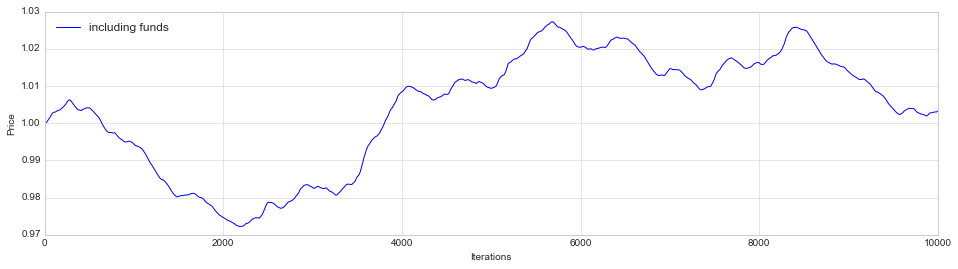

In [41]:
# Plot prices
plot_prices(result)

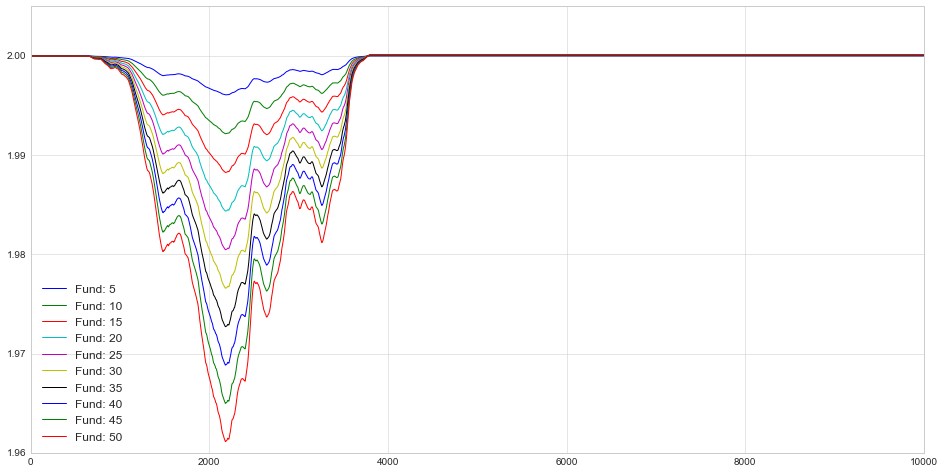

In [42]:
# Plot the wealth of all funds
plt.figure(figsize=(16,8))
plt.plot(result['wealth']);
#plt.savefig("{}simulated_wealth_{}_funds.png".format(outpath, result['num_funds']))
plt.legend(["Fund: {}".format(fund.beta) for fund in result['funds']], loc='best');